In [4]:
import os
import glob
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from keras.models import Model, load_model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Activation, Flatten, GlobalAveragePooling2D

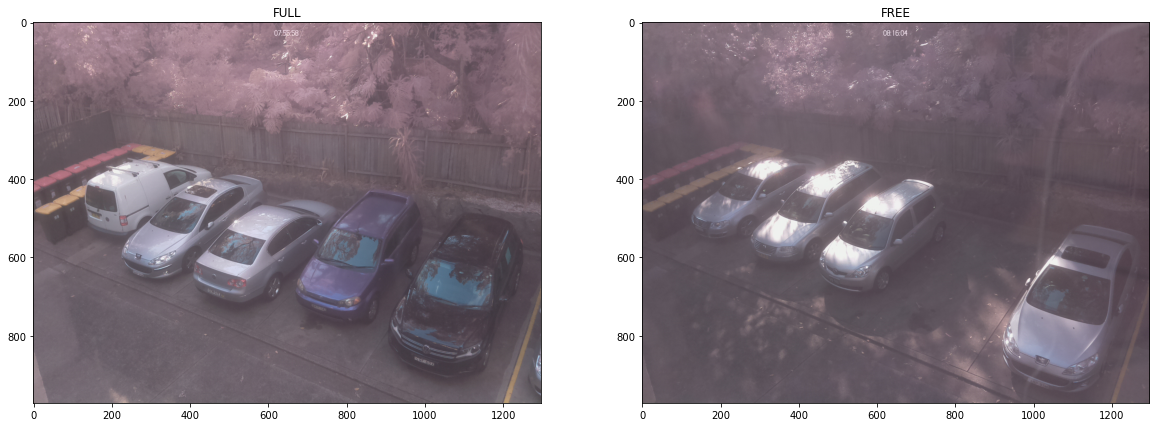

In [5]:
data_path = "./../input/find-a-car-park/data/"

full_list = glob.glob(os.path.join(data_path, 'Full/*.jpg')) # Full Parking lot
free_list = glob.glob(os.path.join(data_path, 'Free/*.jpg'))

plt.figure(figsize=(20, 10))

plt.subplot(1,2,1)
plt.title("FULL")
full_img = plt.imread(full_list[0])
plt.imshow(full_img)

plt.subplot(1,2,2)
plt.title("FREE")
free_img = plt.imread(free_list[0])
plt.imshow(free_img)

plt.show()

In [6]:
train_datagen = ImageDataGenerator(
    rotation_range = 10,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    brightness_range = [0.8, 1.2],
    shear_range = 0.01,
    zoom_range = [0.9, 1.1],
    validation_split = 0.1,
    preprocessing_function = preprocess_input
)
 
val_datagen = ImageDataGenerator(
    validation_split = 0.1,
    preprocessing_function = preprocess_input
)

In [7]:
train_gen = train_datagen.flow_from_directory(
    data_path,
    target_size = (224, 224),
    classes = ['Full', 'Free'],
    class_mode = 'categorical',
    batch_size = 32,
    shuffle = True,
    subset = 'training'
)
 
val_gen = val_datagen.flow_from_directory(
    data_path,
    target_size = (224, 224),
    classes = ['Full', 'Free'],
    class_mode = 'categorical',
    batch_size = 32,
    shuffle = False,
    subset = 'validation'
)

Found 2937 images belonging to 2 classes.
Found 325 images belonging to 2 classes.


In [8]:
print(val_gen.class_indices)

{'Full': 0, 'Free': 1}


In [12]:
base_model = MobileNetV2(input_shape=(224, 224, 3), weights='imagenet', include_top=False)
 
x = base_model.output
x = GlobalAveragePooling2D()(x)
output = Dense(2, activation='softmax')(x)
 
model = Model(inputs=base_model.input, outputs=output)
 
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
 
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________________

In [13]:
for layer in model.layers:
    layer.trainable = True

In [14]:
history = model.fit_generator(
    train_gen,
    validation_data = val_gen,
    epochs = 20,
    steps_per_epoch = len(train_gen) // 32, # 32 is the batch_size
    validation_steps = len(val_gen) // 32,
    callbacks = [
        ModelCheckpoint('./model.h5', monitor = 'val_acc', save_best_only = True, verbose = 1)
    ]
)

if not os.path.isfile("./model.h5"):
    model.save("./model.h5")

Epoch 1/20
2/2 [==============================] - 3s 2s/step - loss: 0.6539 - accuracy: 0.7344
Epoch 2/20
2/2 [==============================] - 2s 982ms/step - loss: 0.7534 - accuracy: 0.7344
Epoch 3/20
2/2 [==============================] - 2s 791ms/step - loss: 0.6791 - accuracy: 0.7500
Epoch 4/20
2/2 [==============================] - 2s 895ms/step - loss: 0.5296 - accuracy: 0.8438
Epoch 5/20
2/2 [==============================] - 2s 772ms/step - loss: 0.3699 - accuracy: 0.8594
Epoch 6/20
2/2 [==============================] - 2s 876ms/step - loss: 0.6782 - accuracy: 0.7812
Epoch 7/20
2/2 [==============================] - 2s 1s/step - loss: 0.3958 - accuracy: 0.8594
Epoch 8/20
2/2 [==============================] - 2s 803ms/step - loss: 0.4268 - accuracy: 0.8594
Epoch 9/20
2/2 [==============================] - 2s 796ms/step - loss: 0.0916 - accuracy: 0.9688
Epoch 10/20
2/2 [==============================] - 2s 803ms/step - loss: 0.1855 - accuracy: 0.9375
Epoch 11/20
2/2 [========

In [ ]:
model = load_model('model.h5')
 
last_weight = model.layers[-1].get_weights()[0] # (1280, 2)

# feature map 을 아웃풋으로 추가함 / 위치 정보를 가져오기 위해서 global average pooling 전 단계에서 추출
new_model = Model(
    inputs = model.input,
    outputs = (
        model.layers[-3].output, # the layer just before GAP, for using spatial features
        model.layers[-1].output
    )
)
 
new_model.summary()

In [ ]:
test_img = img_to_array(load_img(os.path.join(data_path, 'Free/img_129173058.jpg'), target_size=(224, 224)))
 
test_input = preprocess_input(np.expand_dims(test_img.copy(), axis=0))
 
pred = model.predict(test_input)
 
plt.figure(figsize=(8, 8))
plt.title('%.2f%% Free' % (pred[0][1] * 100))
plt.imshow(test_img.astype(np.uint8))

In [ ]:
last_conv_output, pred = new_model.predict(test_input)
 
last_conv_output = np.squeeze(last_conv_output) # (7, 7, 1280)
feature_activation_maps = scipy.ndimage.zoom(last_conv_output, (32, 32, 1), order=1) # (7, 7, 1280) => (224, 224, 1280)
 
pred_class = np.argmax(pred) # 0: Full, 1: Free
predicted_class_weights = last_weight[:, pred_class] # (1280, 1)
 
final_output = np.dot(feature_activation_maps.reshape((224*224, 1280)), predicted_class_weights).reshape((224, 224)) # (224*224, 1280) dot_produt (1280, 1) = (224*224, 1)
 
plt.imshow(final_output, cmap='jet')

NameError: name 'test_img' is not defined

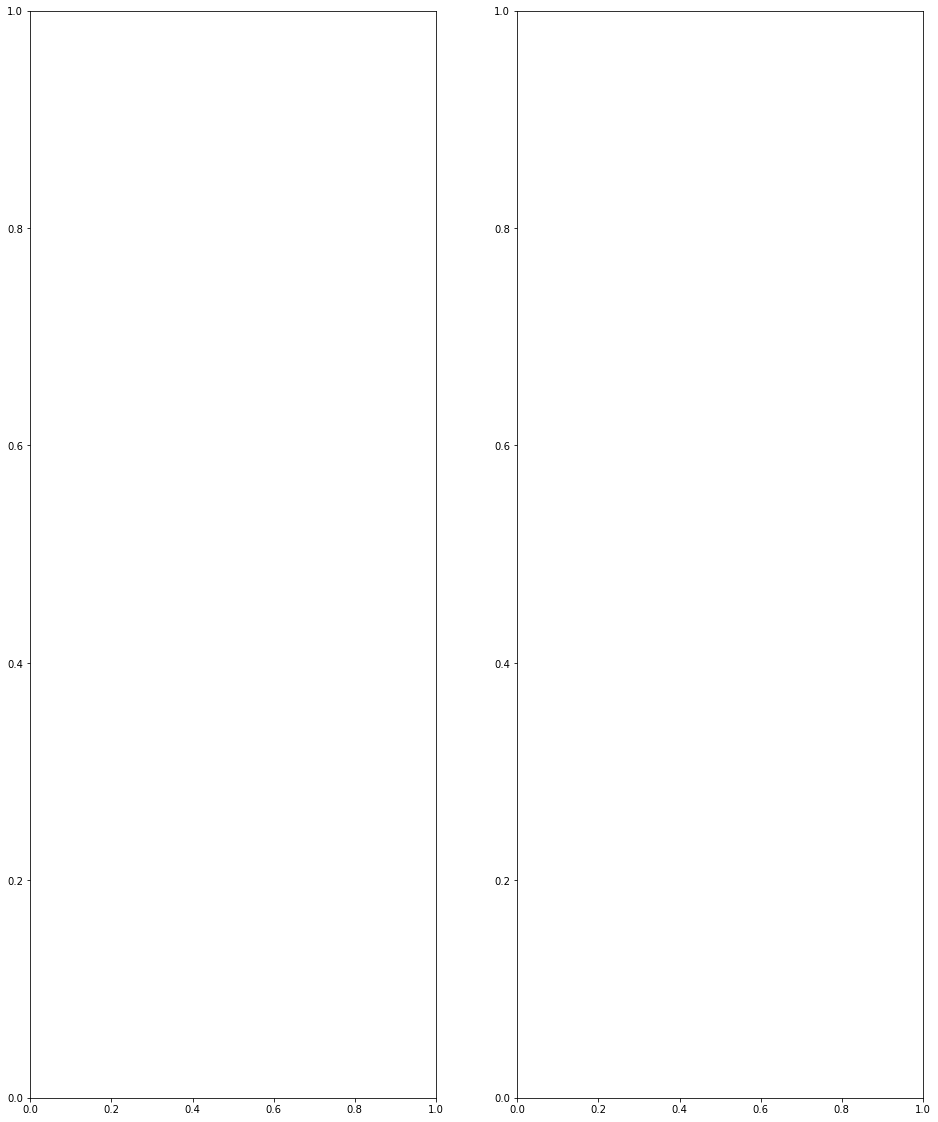

In [3]:
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(16, 20)
 
ax[0].imshow(test_img.astype(np.uint8))
ax[0].set_title('image')
ax[0].axis('off')
 
ax[1].imshow(test_img.astype(np.uint8), alpha=0.5)
ax[1].imshow(final_output, cmap='jet', alpha=0.5)
ax[1].set_title('class activation map')
ax[1].axis('off')
plt.show()